<center><h1>Demo usage</h1></center>

## Beat tracking from MIDI performance recording

In [8]:
from pm2s.features.beat import RNNJointBeatProcessor
import mir_eval
import pretty_midi as pm

# Get one MIDI recording from the A_MAPS dataset
midi_recording = '/import/c4dm-05/ll307/datasets/A-MAPS_1.1/MAPS_MUS-alb_se2_ENSTDkCl.mid'

# Create a beat processor
processor = RNNJointBeatProcessor()

# Process the MIDI recording to the beat predictions
beats_pred = processor.process(midi_recording)

# Ground truth beats
midi_data = pm.PrettyMIDI(midi_recording)
beats_targ = midi_data.get_beats()

# F-measure
beats_pred_trimmed = mir_eval.beat.trim_beats(beats_pred)
beats_targ_trimmed = mir_eval.beat.trim_beats(beats_targ)
f1 = mir_eval.beat.f_measure(beats_targ_trimmed, beats_pred_trimmed)

print('First 10 predicted beats:')
print(beats_pred[:10])
print('First 10 target beats:')
print(beats_targ[:10])
print('F1 score for beat tracking: {}'.format(f1))

First 10 predicted beats:
[0.521985   1.3814865  2.240988   3.114987   4.021977   4.9389765
 5.85696625 6.70853825 7.47664811 8.23669179]
First 10 target beats:
[0.         0.521985   1.379979   2.240988   3.114987   4.021977
 4.9389765  5.85696625 6.70697575 7.47296575]
F1 score for beat tracking: 0.9761092150170649


Plot the beat prediction and piano roll for a short segment:

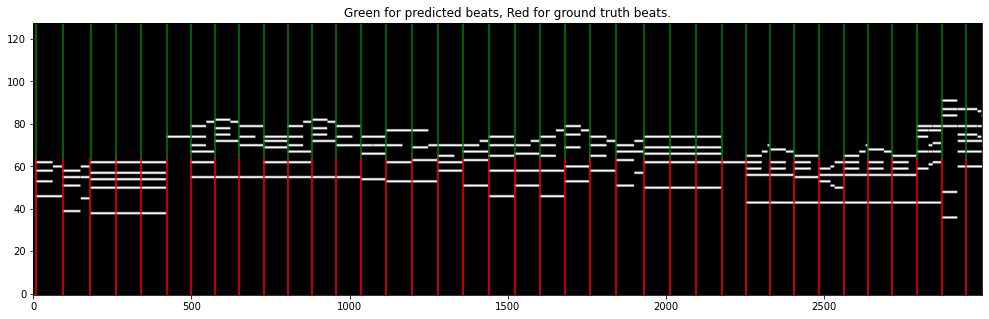

In [21]:
import numpy as np
import pretty_midi as pm
import matplotlib.pyplot as plt

def get_piano_roll(midi_file, start_time, end_time):

    pr = np.zeros((128, int((end_time - start_time) * 100)))

    for instrument in pm.PrettyMIDI(midi_file).instruments:
        for note in instrument.notes:
            if note.start >= end_time or note.end <= start_time:
                continue
            start = int((note.start - start_time) * 100)
            end = int((note.end - start_time) * 100)

            pr[note.pitch, start:end] = 1
    
    return pr

midi_data = pm.PrettyMIDI(midi_recording)
beats_targ = midi_data.get_beats()

start_time, end_time = 20, 50
beats_pred_seg = beats_pred[np.logical_and(beats_pred >= start_time, beats_pred <= end_time)]
beats_targ_seg = beats_targ[np.logical_and(beats_targ >= start_time, beats_targ <= end_time)]
pr_seg = get_piano_roll(midi_recording, start_time, end_time)

plt.figure(figsize=(17, 5))
plt.imshow(pr_seg, aspect='auto', origin='lower', cmap='gray')
for b in beats_pred_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0.5, ymax=1, color='g')
for b in beats_targ_seg:
    plt.axvline(x=(b - start_time) * 100, ymin=0, ymax=0.5, color='r')
plt.title('Green for predicted beats, Red for ground truth beats.')
plt.show()

## Quantisation from a MIDI performance